### Assignment 02

In [510]:
# Import the relevant libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

#### 02 - Logistic Regression

In [511]:
# Load the penguins dataset
df = sns.load_dataset("penguins")
df.dropna(inplace=True)

# Filter rows for 'Adelie' and 'Chinstrap' classes
selected_classes = ['Adelie', 'Chinstrap']
df_filtered = df[df['species'].isin(selected_classes)].copy() # Make a copy to avoid the warning

le = LabelEncoder() # Initialize the LabelEncoder

# Encode the species column
y_encoded = le.fit_transform(df_filtered['species'])
df_filtered['class_encoded'] = y_encoded

# Display the filtered and encoded DataFrame
print (df_filtered[['species', 'class_encoded']])

# Split the data into features (X) and target variable (y)
y = df_filtered['class_encoded']

# X = df_filtered.drop(['class_encoded'], axis=1)   <---    Causes error. Modified below:

X_ = df_filtered.drop(['species', 'sex', 'class_encoded'], axis=1)

# Form X_1 by one-hot encoding the island names and including them as new features
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
islands_encoded = ohe.fit_transform(X_[['island']])
X_1 = pd.concat(
    [
        X_.drop('island', axis=1).reset_index(drop=True),
        pd.DataFrame(islands_encoded, columns=ohe.get_feature_names_out(['island']))
    ], axis=1
)

# Form X_2 by simply dropping the 'island' column
X_2 = X_.drop(['island'], axis=1)

       species  class_encoded
0       Adelie              0
1       Adelie              0
2       Adelie              0
4       Adelie              0
5       Adelie              0
..         ...            ...
215  Chinstrap              1
216  Chinstrap              1
217  Chinstrap              1
218  Chinstrap              1
219  Chinstrap              1

[214 rows x 2 columns]


In [512]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)

# Train the logistic regression model. Here we use sagasolver to learn weights.
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, y_train)

# Predict on the testing data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy :", accuracy)
print (logreg.coef_, logreg.intercept_)

Accuracy : 0.5813953488372093
[[ 2.76140862e-03 -8.24855282e-05  4.76689108e-04 -2.87311519e-04]] [-8.38232907e-06]


d:\UoM\Semester 5\EN3150 - Pattern Recognition\Assignment 02\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [513]:
# Train the logistic regression model again; this time we use liblinear to learn the weights.
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

# Predict on the testing data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy :", accuracy)
print (logreg.coef_, logreg.intercept_)

Accuracy : 1.0
[[ 1.59665154 -1.42501103 -0.15238046 -0.003951  ]] [-0.0755452]


In [514]:
# Initialize StandardScaler
scaler = StandardScaler()

# StandardScale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run both types of regression on the scaled data
for model in ['saga', 'liblinear']:
    logreg = LogisticRegression(solver=model)
    logreg.fit(X_train_scaled, y_train)

    # Predict on the testing data
    y_pred = logreg.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print ("Accuracy with", model, ":", accuracy)
    print (logreg.coef_, logreg.intercept_)

Accuracy with saga : 0.9767441860465116
[[ 3.90450237 -0.82352083  0.18540378 -0.73568185]] [-1.96735643]
Accuracy with liblinear : 0.9767441860465116
[[ 3.77819685 -0.75341497  0.17248526 -0.71597049]] [-1.72205563]


#### 03 - First and Second Order Methods for Logistic Regression

In [515]:
# Generate synthetic data
np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

# Prepend each data point with 1 to incorporate a bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])

# Reshape y as a column vector
y = y.reshape(-1, 1)

# Number of data points
N = X.shape[0]

In [516]:
# Define a function to compute the binary cross entropy
def BCE(y, y_hat):
    return -(y.T @ np.log(y_hat + 1e-12) + (1 - y).T @ np.log(1 - y_hat + 1e-12))[0]

# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

BGD_losses = []
NM_losses = []

In [517]:
## Batch Gradient Descent

# Initialize weights
np.random.seed(1)
w_BGD = np.zeros((X.shape[1], 1))

# Define a learning rate
alpha = 2

for i in range(20):
    # Make predictions
    y_hat = sigmoid(X @ w_BGD)

    # Compute the gradient
    grad = (X.T @ (y - y_hat)) / N

    # Update w
    w_BGD += alpha * grad

    # Compute the loss
    BGD_losses.append(BCE(y, y_hat))

In [518]:
## Newton's Method
 
# Initialize weights
np.random.seed(1)
w_NM = np.zeros((X.shape[1], 1))

# Define a learning rate
alpha = 3

for i in range(20):
    y_hat = sigmoid(X @ w_NM)
    
    # Compute the gradient
    g = (X.T @ (y_hat - y)) / N

    # Compute the Hessian
    S = np.diagflat(y_hat * (1 - y_hat))
    H = (X.T @ S @ X) / N

    # Find the step to take and update w
    step = np.linalg.solve(H, g)
    w_NM -= alpha * step

    # Compute the loss
    NM_losses.append(BCE(y, y_hat))

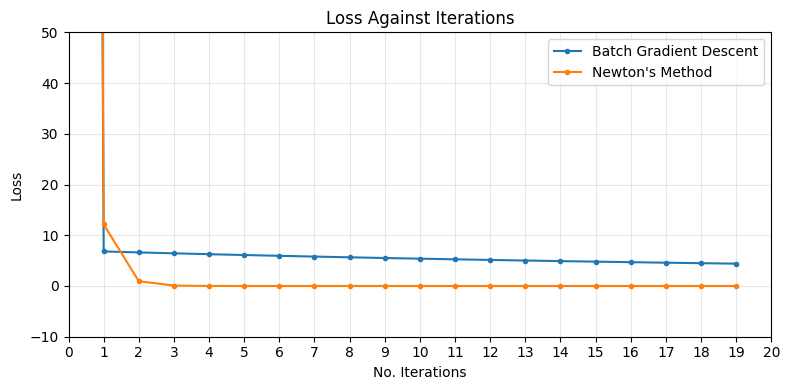

In [519]:
plt.figure(figsize=(8, 4))

plt.title("Loss Against Iterations")

plt.plot(BGD_losses, label="Batch Gradient Descent", marker=".")
plt.plot(NM_losses, label="Newton's Method", marker=".")

plt.xlim(0, 20)
plt.ylim(-10, 50)
plt.xlabel("No. Iterations")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 21, 1))

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

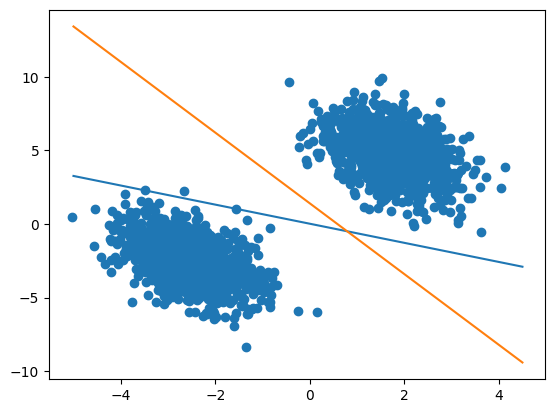

In [520]:
plt.scatter(X[:, 1], X[:, 2])
x = np.arange(-5, 5, 0.5)
y = -(w_BGD[0] + w_BGD[1] * x) / w_BGD[2]
plt.plot(x, y)
y = -(w_NM[0] + w_NM[1] * x) / w_NM[2]
plt.plot(x, y)

In [ ]:
# Generate synthetic data again, with different centers
np.random.seed(0)
centers = [[2, 2], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
X = np.dot(X, transformation)

# Prepend each data point with 1 to incorporate a bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])

# Reshape y as a column vector
y = y.reshape(-1, 1)

# Number of data points
N = X.shape[0]